In [5]:
import scipy.linalg as lin
import numpy as np
import itertools
import time
import sys
import math
import re
import csv
import pandas as pd

#Assume the first r rows of a forms an orthonormal basis
#Returns the projection of x onto the orthogonal complement of the rows of a
#scaled to unit length
def make_orthogonal(a,r,x):
    if np.linalg.norm(x)<1e-8:
        return None
    if r==0:
        return x/np.linalg.norm(x)
    u = x
    for j in range(0,int(r/100)):
        u = u - a[range(j*100,(j+1)*100)].T @ (a[range(j*100,(j+1)*100)] @ u)
    for j in range(int(r/100)*100,r):
        u = u - np.inner(u,a[j]) * a[j]
    norm = np.linalg.norm(u)
    if norm < np.linalg.norm(x)/100:
        return None
    u = u/norm
    return u

def round_coloring(a,x,norm = np.inf, balanced=False):
    start = time.time()
    n = a.shape[1]
    abs = np.absolute(x)
    live = (abs < 1.0-1e-4)
    #first sample each entry
    samples = np.random.random_sample(n)
    signs = np.ones(n)
    signs[samples < (1.0-abs)/2.0] = -1
    flipped = np.multiply(x,signs)
    y = np.sign(flipped)
    y[y==0]=1
    #then try all assignments to the coordinates that were live
    num_live = sum(live)
    if num_live<=10:
        live_indices = [i for i, x in enumerate(live) if x]
        ay = a@y
        sub_a = a[:,live_indices]
        sub_y = y[live_indices]
        sub_ay = sub_a @ sub_y
        a_outside = ay - sub_ay
        best_sub_y = sub_y
        best_norm = np.linalg.norm(ay,ord=norm)
        sign_flips = np.ones(num_live)
        while True:
            at = 0
            while at<num_live and sign_flips[at]==-1:
                sign_flips[at]=1
                at = at+1
            if at==num_live:
                break
            sign_flips[at]=-1
            new_sub_y = np.multiply(sub_y,sign_flips)
            new_sub_ay = sub_a @ new_sub_y
            new_ay = a_outside + new_sub_ay
            new_norm = np.linalg.norm(new_ay,ord=norm)
            if new_norm < best_norm:
                best_norm = new_norm
                best_sub_y = new_sub_y
        y[live_indices] = best_sub_y
    #balance the vector in case we need to
    if balanced:
        while True:
            toFlip = 1
            if sum(y==1) < n/2:
                toFlip = -1
            ofToFlip = sum(y==toFlip)
            needToFlip = int(ofToFlip-n/2)
            if needToFlip==0:
                break
            listOfToFlip = [i for i, x in enumerate(y) if x==toFlip]
            ay = a @ y
            best_norm = 1e27
            #try all single flips
            best_to_flip = 0
            for i in listOfToFlip:
                col = a[:,i]
                new_ay = ay - (2*col*y[i])
                new_norm = np.linalg.norm(new_ay,ord=norm)
                if new_norm < best_norm:
                    best_norm = new_norm
                    best_to_flip = i
            y[best_to_flip] = -y[best_to_flip]
    return y

def to_square(a,x,balanced=False):
    n = a.shape[1]
    m = a.shape[0]
    if n<=m:
        return x
    live = n
    orth = np.zeros((n,n))
    is_live = np.ones(n)
    num_orth = 0
    for i in range(0,m):
        p = make_orthogonal(orth,num_orth,a[i])
        if not p is None:
            orth[num_orth] = p
            num_orth = num_orth + 1
    if balanced:
        all_ones = np.ones(n)
        p = make_orthogonal(orth,num_orth,all_ones)
        if np.linalg.norm(p) > 0.01:
            orth[num_orth] = p
            num_orth = num_orth + 1
    while num_orth < n and sum(is_live) > 8:
        #sample a random vector
        g = np.random.randn(n)
        #make it orthogonal to all in orth
        gamma = make_orthogonal(orth,num_orth,g)
        if gamma is None:
            break
        #set all that are not live to 0 for numerical stability
        for i in range(0,n):
            if not is_live[i]:
                gamma[i] = 0
        #find coord that freezes first
        delta = 1e30
        for i in range(0,n):
            if is_live[i] and abs(gamma[i]) > 1e-7:
                dist = 0
                if gamma[i] * x[i] >= 0:
                    dist = (1-abs(x[i]))/abs(gamma[i])
                else:
                    dist = (1+abs(x[i]))/abs(gamma[i])
                if dist < delta:
                    delta = dist
        if delta > 1e25:
            break
        x = x + delta * gamma
        for i in range(0,n):
            if is_live[i] and abs(x[i]) >= 1-1e-6:
                is_live[i] = 0
                e = np.zeros(n)
                e[i] = 1
                p = make_orthogonal(orth,num_orth,e)
                if not p is None:
                    orth[num_orth] = p
                    num_orth = num_orth+1
                    if num_orth>=n:
                        break
    return x

def partial_color(a,x,norm=np.inf,balanced=False):
    if norm==np.inf:
        return partial_infty_color(a,x,balanced)
    if norm==2:
        return partial_l2_color(a,x,balanced)

def partial_l2_color(a, x, balanced=False):
    n = a.shape[1]
    m = a.shape[0]
    delta=1e-5

    #count number of live coordinates
    abs_x = np.absolute(x)
    is_live = (abs_x < 1.0-delta)
    initial_is_live = is_live.copy()
    live = is_live.sum()
    if live<8: 
        return True
    initial_live=live
    #extract the live coordinates and columns
    y = x[initial_is_live]
    b = a[:,initial_is_live]
    #compute eigenvectors of bTb
    bTb = b.T @ b
    w, v = lin.eigh(bTb)
    num_iters = 0
    was_live = np.ones(initial_live,dtype=bool)
    num_frozen = 0
    orth = np.zeros((initial_live,initial_live))
    num_orth = 0
    to_add = v[:,range(initial_live-int(initial_live/2), initial_live)].T
    orth[range(0,to_add.shape[0])] = to_add
    num_orth = to_add.shape[0]
    if balanced:
        ones = np.ones(initial_live)
        ones = make_orthogonal(orth,num_orth,ones)
        if not ones is None:
            orth[num_orth] = ones
            num_orth = num_orth+1
    while int((live*3/2)) > initial_live:
        #will have at most 1/3 * initial_live that are frozen
        abs_y = np.absolute(y)
        #start by freezing new frozen coordinates
        is_live = (abs_y < 1.0-delta)
        diff = is_live!=was_live
        num_diff = diff.sum()
        if num_diff>0:
            for i in range(0,initial_live):
                if diff[i]:
                    e = np.zeros(initial_live)
                    e[i] = 1
                    p = make_orthogonal(orth,num_orth,e)
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_frozen = num_frozen + 1
            was_live = is_live
        if num_orth>=initial_live:
            break
        num_iters = num_iters+1
        ax = a @ x
        #sample a random vector
        g = np.random.randn(initial_live)
        #make it orthogonal to all in orth
        gamma = make_orthogonal(orth,num_orth,g)
        if gamma is None:
            break
        #set coords to zero where not live, due to numerical stability
        for i in range(0,initial_live):
            if not is_live[i]:
                gamma[i] = 0
        if np.linalg.norm(gamma,ord=np.inf)==0:
            break
        if np.inner(ax,b @ gamma) > 0:
            gamma = -gamma
        coord_mult = np.multiply(gamma,y)
        val = np.where(coord_mult < 0, (1+abs(y))/(1e-27+abs(gamma)), (1-abs(y))/(1e-27 + abs(gamma)))
        val = np.where(is_live, val, 1e27)
        z = min(val)
        y = y + z*gamma
        x[initial_is_live] = y
        new_abs_y = np.absolute(y)
        is_live = (new_abs_y < 1.0-delta)
        live = is_live.sum()
    return False

def partial_infty_color(a, x, balanced=False):
    n = a.shape[1]
    m = a.shape[0]
    delta=1e-5

    #count number of live coordinates
    abs_x = np.absolute(x)
    is_live = (abs_x < 1.0-delta)
    initial_is_live = is_live.copy()
    live = is_live.sum()
    if live<8: 
        return True
    initial_live=live
    #extract the live coordinates and columns
    y = x[initial_is_live]
    b = a[:,initial_is_live]
    num_iters = 0
    was_live = np.ones(initial_live,dtype=bool)
    was_small = np.ones(m,dtype=bool)
    orth = np.zeros((initial_live,initial_live))
    num_orth = 0
    if balanced:
        ones = np.ones(initial_live)
        ones = ones/np.sqrt(initial_live)
        orth[0] = ones
        num_orth = num_orth+1
    num_frozen = 0
    num_big = 0
    num_initial = 0
    while int((live*5)/4) > initial_live:
        #will have at most 1/3 * initial_live that are frozen
        #freeze up to 1/3 largest coords
        abs_y = np.absolute(y)
        #start by freezing new frozen coordinates
        is_live = (abs_y < 1.0-delta)
        diff = is_live!=was_live
        num_diff = diff.sum()
        if num_diff>0:
            for i in range(0,initial_live):
                if diff[i]:
                    e = np.zeros(initial_live)
                    e[i] = 1
                    p = make_orthogonal(orth,num_orth,e)
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_frozen = num_frozen + 1
            was_live = is_live
        if num_orth>=initial_live:
            break
        #may freeze same number of rows based on abs value
        num_iters = num_iters+1
        ax = a @ x
        abs_ax = np.absolute(ax)
        if num_initial < initial_live/4:
            sorted_indices = np.argsort(-abs_ax)
            for i in range(0, m):
                if was_small[sorted_indices[i]]:
                    p = make_orthogonal(orth,num_orth,b[sorted_indices[i]])
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_initial = num_initial + 1
                    was_small[sorted_indices[i]] = False
                    if num_initial >= initial_live/4:
                        break
        if num_orth>=initial_live:
            break
        if num_big < num_frozen:
            sorted_indices = np.argsort(-abs_ax)
            for i in range(0,m):
                if was_small[sorted_indices[i]]:
                    p = make_orthogonal(orth,num_orth,b[sorted_indices[i]])
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_big = num_big + 1
                    was_small[sorted_indices[i]] = False
                    if num_big >= num_frozen:
                        break
        if num_orth>=initial_live:
            break
        #sample a random vector
        g = np.random.randn(initial_live)
        #make it orthogonal to all in orth
        gamma = make_orthogonal(orth,num_orth,g)
        if gamma is None:
            break
        #set coords to zero where not live, due to numerical stability
        for i in range(0,initial_live):
            if not is_live[i]:
                gamma[i] = 0
        if np.linalg.norm(gamma,ord=np.inf)==0:
            break
        if np.inner(ax,b @ gamma) > 0:
            gamma = -gamma
        coord_mult = np.multiply(gamma,y)
        val = np.where(coord_mult < 0, (1+abs(y))/(1e-27+abs(gamma)), (1-abs(y))/(1e-27 + abs(gamma)))
        val = np.where(is_live, val, 1e27)
        z = min(val)
        y = y + z*gamma
        x[initial_is_live] = y
        new_abs_y = np.absolute(y)
        is_live = (new_abs_y < 1.0-delta)
        live = is_live.sum()
    return False


def local_improvements(a,x,time_limit,norm=np.inf, balanced=False):
    ax = a @ x
    best_norm = np.linalg.norm(ax,ord=norm)
    start_time = time.time()
    num_flip = min(7,len(x))
    if balanced and num_flip%2==1:
        num_flip = num_flip + 1
    iters = 0
    while True:
        iters = iters+1
        #Try flipping random coords
        for iteration in range(0,a.shape[1]):
            sampled_coords = np.random.randint(0,a.shape[1],num_flip)
            sampled_coords = np.sort(sampled_coords)
            allDistinct=True
            for i in range(0,num_flip-1):
                if sampled_coords[i]==sampled_coords[i+1]:
                    allDistinct=False
            if not allDistinct:
                continue
            if balanced:
                #check equal num of +1 and -1
                sum_is=0
                for i in range(0,num_flip):
                    sum_is = sum_is + x[sampled_coords[i]]
                if sum_is!=0:
                    continue
            subcols = a[:,sampled_coords]
            subx = [x[index] for index in sampled_coords]
            bx = ax - 2*(subcols @ subx)
            the_norm = np.linalg.norm(bx,ord=norm)
            if the_norm<best_norm:
                best_norm = the_norm
                for i in sampled_coords:
                    x[i] = -x[i]
                ax = bx
        if time.time()-start_time > time_limit:
            break 
    return x

def basic_local_search(a,x,norm,balanced=False):
    ax = a@x
    best_norm = np.linalg.norm(ax,ord=norm)
    improved=True
    while improved:
        improved=False
        #Try flipping single coords
        for i in range(0,a.shape[1]):
            flipped = ax - 2*x[i]*a[:,i]
            if np.linalg.norm(flipped, ord=norm) < best_norm:
                if balanced:
                    #must find one to swap with
                    for j in range(0,a.shape[1]):
                        if x[i]==x[j]:
                            continue
                        final_flipped = flipped - 2*x[j]*a[:,j]
                        if np.linalg.norm(final_flipped,ord=norm) < best_norm:
                            ax = final_flipped
                            x[i] = -x[i]
                            x[j] = -x[j]
                            best_norm = np.linalg.norm(final_flipped,ord=norm)
                            improved=True
                            break
                else:
                    ax = flipped
                    x[i] = -x[i]
                    best_norm = np.linalg.norm(flipped,ord=norm)
                    improved=True
    return x

def greedy(a,norm,balanced=False):
    x = np.zeros(a.shape[1])
    if balanced:
        so_far = np.zeros(a.shape[0])
        for i in range(0,a.shape[1]):
            if i%2==1:
                continue
            test = so_far + a[:,i]
            test_minus = so_far - a[:,i]
            if i<a.shape[1]-1:
                test = test - a[:,i+1]
                test_minus = test_minus + a[:,i+1]
            if np.linalg.norm(test,ord=norm) < np.linalg.norm(test_minus,ord=norm):
                x[i] = 1
                if i<a.shape[1]-1:
                    x[i+1]=-1
            else:
                x[i] = -1
                if i<a.shape[1]-1:
                    x[i+1] = 1
    else:
        x[0] = 1
        so_far = a[:,0]
        for i in range(1,a.shape[1]):
            test = so_far + a[:,i]
            test_minus = so_far - a[:,i]
            if np.linalg.norm(test,ord=norm) <  np.linalg.norm(test_minus,ord=norm):
                x[i] = 1
            else:
                x[i] = -1
            so_far = so_far + x[i]*a[:,i]
    return x

def discrepancy_minimize(a, norm=np.inf, balanced=False, local_search=0.3):
    n = a.shape[1]
    x = np.zeros(n)
    start_time = time.time()
    x = to_square(a,x,balanced)
    while not partial_color(a,x, norm, balanced):
        pass
    end_time = time.time()
    elapsed = end_time - start_time
    y = round_coloring(a,x,norm, balanced)
    y = basic_local_search(a,y,norm,balanced)
    #check if greedy approach is better
    g = greedy(a,norm,balanced)
    g = basic_local_search(a,g,norm,balanced)
    if np.linalg.norm(a@g,ord=norm) < np.linalg.norm(a@y, ord=norm):
        y = g
    y = local_improvements(a,y, elapsed*local_search, norm, balanced)
    y = basic_local_search(a,y,norm,balanced)
    total_elapsed = time.time()-start_time
    #make sure we return an int array, not floating
    z = np.zeros(n)
    for i in range(n):
        if y[i]==-1:
            z[i]=-1
        else:
            z[i]=1
    return z

def Com(a):
    n = a.shape[0]
    b = np.zeros(n)
    for i in range(n):
        if a[i] == 1:
            b[i]= 0
        else:
            b[i]= 1
    return b   

#python

def FindDisc(a, v):
    n = a.shape[1]
    m = a.shape[0]
    disc = 0
    for i in range(m):
        newdisc = 0
        for j in range(n):
            newdisc = newdisc + v[j]
            #print(newdisc)
        modisc = abs(newdisc)
        if modisc >= disc:
            disc = modisc
    return disc



In [6]:
##################3ALL Fair#################3
from random import *
def fair(x,a,b,alpha,R):
    #x-actual a=kesper b=classifier
    
    a_acc=0
    b_acc=0
    f_acc=0
    n= x.shape[0]
    f= np.zeros(n) 
    count=0
    acc=0
    for i in range(n):
        z=random()
        if z < alpha:
            f[i]= a[i] 
            count=count+1
        else:
            f[i]= b[i]
                    
        
    for i in range(n):
         if a[i] == x[i]:
                a_acc=a_acc+1
    for i in range(n):
         if b[i] == x[i]:
                b_acc=b_acc+1
    for i in range(n):
         if f[i] == x[i]:
                f_acc=f_acc+1

    a_acc_percent=a_acc/n            
    b_acc_percent=b_acc/n  
    f_acc_percent=f_acc/n  
    count1=0
    count2=0
    for i in range(R.shape[1]):
        if(R[0,i]==1):
            if f[i]==1:
                  count1+=1
        else:
            if f[i]==1:
                count2+=1
            
    ratio=float(count1/count2)  
#############################################################
    
    print("###############################")
#     print(f)
#     print(x)
#     print(b)
#     print(a_acc_percent,b_acc_percent)
    print("###############################")
    #kasper svm final ratio
    return a_acc_percent,b_acc_percent,f_acc_percent,ratio
        

In [4]:
import matplotlib.pyplot as plt
def ploting(y_train,u1,y_1,R):
    alpha1_l=[]
    c1_l=[]
    ratio_l=[]
    
    ####### plot################   
    for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
        a,b,c,ratio  = fair(y_train,u1,y_1,alpha,R)
        ratio_l.append(ratio)
        alpha1_l.append(alpha)
        c1_l.append(c)
    print(c1_l)
    plt.plot( alpha1_l, c1_l, 'ro')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Fairness(Alpha)')
    plt.ylabel('Train Accuracy')
    plt.title('Accuracy V/S Fairness tradeoff for ProPublica dataset')
    alpha = np.linspace(0, 1, 10) 
    y = alpha*(min(c1_l) - max(c1_l)) + max(c1_l)
    # fig = plt.figure(figsize = (10, 5)) 
    plt.plot(alpha, y) 
    plt.legend(["Experimental", "Theoretical"])
    plt.show() 
#   print(min(c1_l) , max(c1_l))
    
    
    
#     print("ratio------------------")
#     alpha1=[0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]
#     plt.plot( alpha1, ratio, 'ro')
#     plt.axis([0, 1, 0, 20])
#     plt.xlabel('Fairness(Alpha)')
#     plt.ylabel('Male/Female Ratio')
#     plt.title('Variation of bias w.r.t Fairness')
#     alpha = np.linspace(0, 1, 10) 
#     y = 4
#     # fig = plt.figure(figsize = (10, 5)) 
#     plt.plot(1, y) 
#     plt.show() 

    return 1
#########################################################################
#########################################################################

def ploting_lp_prop(y_train,u1,y_1,R):
    alpha1_l=[]
    c1_l=[]
    ratio_l=[]
    
    ####### plot################   
    for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
        a,b,c,ratio  = fair(y_train,u1,y_1,alpha,R)
        ratio_l.append(ratio)
        alpha1_l.append(alpha)
        c1_l.append(c)
#     print(c1_l)
#     plt.plot( alpha1_l, c1_l, 'ro')
#     plt.axis([0, 1, 0, 1])
#     plt.xlabel('Fairness(Alpha)')
#     plt.ylabel('Train Accuracy')
#     plt.title('Accuracy V/S Fairness tradeoff for ProPublica dataset')
#     alpha = np.linspace(0, 1, 10) 
#     y = alpha*(min(c1_l) - max(c1_l)) + max(c1_l)
#     # fig = plt.figure(figsize = (10, 5)) 
#     plt.plot(alpha, y) 
#     plt.legend(["Experimental", "Theoretical"])
#     plt.show() 
#   print(min(c1_l) , max(c1_l))
    
    

    return c1_l[10]

In [3]:
def ProPub1():
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((7, n), dtype = int)
    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

    for i in range(n):
        if x2[i] == 'African-American':
            R[2][i]= 1
        elif x2[i] == 'Caucasian':
            R[3][i]= 1
        elif x2[i] == 'Hispanic':
            R[4][i]= 1
        elif x2[i] == 'Asia':
            R[5][i]= 1
        else:
            R[6][i]= 1

    racidivism_kasper= discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)
    print(r)
    ##############################################
    racidivism1={}
    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
            racidivism1[i]=0 
            racidivism2[i]=1
        else:
            racidivism1[i]=1
            racidivism2[i]=0

    racidivismu1=racidivism1  
    racidivismu2=racidivism2  
#     print(racidivismu1)
#     print(racidivismu2)   
    print("discripency is:")
    print(r,math.sqrt(n*math.log2(m)))
    return racidivismu1,racidivismu2,R

def ProPub1_gender():
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((2, n), dtype = int)
    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

    racidivism_kasper= discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)
    print(r)
    ##############################################
    racidivism1={}
    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
            racidivism1[i]=1
            racidivism2[i]=0
        else:
            racidivism1[i]=0
            racidivism2[i]=1

    racidivismu1=racidivism1  
    racidivismu2=racidivism2  
#     print(racidivismu1)
#     print(racidivismu2)   
#     print(r,math.sqrt(n*math.log2(m)))
    return racidivismu1,racidivismu2,R
def ProPub1_race():
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((5, n), dtype = int)
    for i in range(n):
        if x2[i] == 'African-American':
            R[0][i]= 1
        elif x2[i] == 'Caucasian':
            R[1][i]= 1
        elif x2[i] == 'Hispanic':
            R[2][i]= 1
        elif x2[i] == 'Asia':
            R[3][i]= 1
        else:
            R[4][i]= 1

    racidivism_kasper= discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,racidivism_kasper)
    print(r)
    ##############################################
    racidivism1={}
    racidivism2={}
    for i in range(racidivism_kasper.shape[0]):
        if racidivism_kasper[i]==1:
            racidivism1[i]=1 
            racidivism2[i]=0
        else:
            racidivism1[i]=0
            racidivism2[i]=1

    racidivismu1=racidivism1  
    racidivismu2=racidivism2  
#     print(racidivismu1)
#     print(racidivismu2)   
#     print(r,math.sqrt(n*math.log2(m)))
    return racidivismu1,racidivismu2,R


In [1]:
#SVM ProPub1
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%pylab inline
from random import *
from subprocess import check_output
def ProPub1_svm():
    print(check_output(["ls", "../input"]).decode("utf8"))

    # Any results you write to the current directory are saved as output.
    #Reading data from CSV file
    df = pd.read_csv('../input/1ProPublica_racidivism.csv')
    print(df.head())
    df=df.drop(columns=['age_cat','c_charge_desc'])

    df1 = df.copy()
    df1 = pd.get_dummies(df1, columns=['sex','race','c_charge_degree','score_text','sex-race'], prefix = ['sex','race','ccd','st','sr'])
    print(df1.loc[:,'two_year_recid'])
    print(df1.shape[1])
    df1['2_year_racidivism'] = df1.loc[:,'two_year_recid']
    print(df1.shape[1])
    df1=df1.drop(columns=['two_year_recid'])
    print(df1.head())
    print(df1.shape[1])

    #Defining data and label
    X = df1.iloc[:, 0:30]
    y = df1.iloc[:, 31]

    #Split data into training and test datasets (training will be based on 70% of data)
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,shuffle=False) 
    #test_size: if integer, number of examples into test dataset; if between 0.0 and 1.0, means proportion
    print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))


    #Scaling data
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score

    sc = StandardScaler(with_mean=False)
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    #X_train_std and X_test_std are the scaled datasets to be used in algorithms

    #Applying SVC (Support Vector Classification)
    from sklearn.svm import SVC
    svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
    svm.fit(X_train_std, y_train)
    print('The accuracy of the SVM classifier on training data is {:.2f}'.format(svm.score(X_train_std, y_train)))
    print('The accuracy of the SVM classifier on test data is {:.2f}'.format(svm.score(X_test_std, y_test)))
    print('####Train prediction Label###############################################')
    y_1=svm.predict(X_train_std)
    print(y_1)

    # print(y_1[2:3])
    # print(y_1[3:4])
    # print(y_1[4:5])
    # for i in range(X_train.shape[0]):
    #      print(y_1[i])


    print('####Actual Train Label###############################################')
    # print(y_train)

    # y_train.to_numpy()

    # for i in range(X_train.shape[0]):
    #     print(y_train[i])

    ###############################################
    print('####Change to colors###############################################')
    count=0
    for i in range(X_train.shape[0]):
        if y_1[i] == y_train[i]:
            count=count+1
    # print(count)    

    # y_trainx=np.zeros((1,X_train.shape[0]),dtype= int)

    # for i in range(X_train.shape[0]):
    #     if y_train[i]==1:
    #         y_trainx[i]=-1
    #     else:
    #         y_trainx[i]=1



    # for i in range(X_train.shape[0]):
    #     if y_1[i]==1:
    #         y_1x[i]=-1
    #     else:
    #         y_1x[i]=1



#     print('####Test###############################################')
#     y_2=svm.predict(X_test_std)
    
    return y_1,y_train
     



Populating the interactive namespace from numpy and matplotlib


0.0
discripency is:
0.0 128.18948413813288
13ProPublica_violent_racidivism.csv
1ProPublica_racidivism.csv
2adult.csv
3germandata_numeric.txt
adult.csv

0       0
1       1
2       1
3       0
4       1
       ..
6162    0
6163    0
6164    0
6165    0
6166    1
Name: two_year_recid, Length: 6167, dtype: int64
32
33
   age  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0   69              0               0                0             0   
1   34              0               0                0             0   
2   24              0               0                1             4   
3   44              0               0                0             0   
4   41              0               0                0            14   

   decile_score  sex_Female  sex_Male  race_African-American  race_Asian  ...  \
0             1           0         1                      0           0  ...   
1             3           0         1                      1           0  ...   
2      

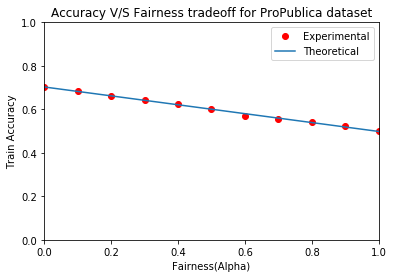

1

In [7]:
#####################kasper##############3

# u1,u2,R= ProPub1()
# y_1,y_train=ProPub1_svm()
# ploting(y_train,u1,y_1,R)
#[0.7029657089898054, 0.6784059314179796, 0.6638090824837812, 0.6322984244670992, 0.6167747914735866, 0.5996292863762743, 0.5753012048192772, 0.556533827618165, 0.5347544022242817, 0.5094995366079703, 0.48841519925857274]
u1,u2,R= ProPub1()
y_1,y_train=ProPub1_svm()
ploting(y_train,u2,y_1,R)
#[0.7029657089898054, 0.6839666357738647, 0.6672845227062094, 0.6334569045412419, 0.6202502316960148, 0.6100556070435589, 0.5848007414272475, 0.5634847080630213, 0.5456441149212233, 0.5173772011121409, 0.49976830398517147]


In [ ]:
#####################kasper##############3
u1,u2,R= ProPub1_gender()
y_1,y_train=ProPub1_svm()
ploting(y_train,u1,y_1,R)

# u1,u2,R= ProPub1_gender()
# y_1,y_train=ProPub1_svm()
# ploting(y_train,u2,y_1,R)

In [ ]:
#####################kasper##############3
u1,u2,R= ProPub1_race()
y_1,y_train=ProPub1_svm()
ploting(y_train,u1,y_1,R)

# u1,u2,R= ProPub1_race()
# y_1,y_train=ProPub1_svm()
# ploting(y_train,u2,y_1,R)

In [ ]:
#####################LP min max##############3
# y_1,y_train=ProPub1_svm()
# maxi=0
# for i in range(0,4000,100) :
#     u1,u2,R=min_max_lp_all(i)
#     min_max=ploting_lp_prop(y_train,u1,y_1,R)
#     if min_max>maxi:
#         maxi=min_max
#         remember=i
#     print(maxi)
      
# print(maxi)
# print(remember)

##################################################3

y_1,y_train=ProPub1_svm()
maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]
for eps in range(0,4000,100) :
    count1=0
    count2=0
    u1,u2,R=min_max_lp_all(eps)
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j]):
                count1+=1
    acc1=float(count1/y_train.shape[0])        
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j]):
                count2+=1
    acc2=float(count2/y_train.shape[0])        
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2)   
print(acc1_l)     
print(acc2_l)      

import matplotlib.pyplot as plt
import numpy as np
acc1_l=[0.5152919369786839, 0.5085727525486562, 0.5048656163113995, 0.5104263206672845, 0.4819277108433735, 0.4860982391102873, 0.49212233549582945, 0.49304911955514363, 0.4860982391102873, 0.484708063021316, 0.4823911028730306, 0.4823911028730306, 0.479610750695088, 0.4789156626506024, 0.48123262279888784, 0.46825764596848934, 0.4696478220574606, 0.4705746061167748, 0.47335495829471735, 0.47335495829471735, 0.4752085264133457, 0.47706209453197407, 0.48030583873957367, 0.4798424467099166, 0.47752548656163113, 0.47659870250231695, 0.47428174235403153, 0.47289156626506024, 0.4696478220574606, 0.4650139017608897, 0.4691844300278035, 0.4677942539388322, 0.4626969416126043, 0.46362372567191845, 0.4594531974050046, 0.45296570898980537, 0.4522706209453197, 0.4522706209453197, 0.4522706209453197, 0.4522706209453197]
acc2_l=[0.484708063021316, 0.49142724745134386, 0.4951343836886006, 0.48957367933271545, 0.5180722891566265, 0.5139017608897127, 0.5078776645041705, 0.5069508804448564, 0.5139017608897127, 0.5152919369786839, 0.5176088971269694, 0.5176088971269694, 0.5203892493049119, 0.5210843373493976, 0.5187673772011121, 0.5317423540315107, 0.5303521779425394, 0.5294253938832252, 0.5266450417052827, 0.5266450417052827, 0.5247914735866543, 0.522937905468026, 0.5196941612604263, 0.5201575532900834, 0.5224745134383688, 0.523401297497683, 0.5257182576459685, 0.5271084337349398, 0.5303521779425394, 0.5349860982391103, 0.5308155699721965, 0.5322057460611678, 0.5373030583873958, 0.5363762743280815, 0.5405468025949953, 0.5470342910101946, 0.5477293790546802, 0.5477293790546802, 0.5477293790546802, 0.5477293790546802]

plt.axis([0, 3900, 30, 60])
plt.xlabel('Fairness(Alpha)')
plt.ylabel('Train Accuracy')
plt.title('Accuracy V/S Fairness tradeoff for ProPublica dataset')
# 
var = np.linspace(0, 40, 10) 
plt.plot(epsilon_l,acc1_l)   
plt.plot(epsilon_l,acc2_l)
plt.legend(["Experimental LP", "Experimental  lp"])
plt.show() 
#[0.484708063021316, 0.49142724745134386, 0.4951343836886006, 0.48957367933271545, 0.5180722891566265, 0.5139017608897127, 0.5078776645041705, 0.5069508804448564, 0.5139017608897127, 0.5152919369786839, 0.5176088971269694, 0.5176088971269694, 0.5203892493049119, 0.5210843373493976, 0.5187673772011121, 0.5317423540315107, 0.5303521779425394, 0.5294253938832252, 0.5266450417052827, 0.5266450417052827, 0.5247914735866543, 0.522937905468026, 0.5196941612604263, 0.5201575532900834, 0.5224745134383688, 0.523401297497683, 0.5257182576459685, 0.5271084337349398, 0.5303521779425394, 0.5349860982391103, 0.5308155699721965, 0.5322057460611678, 0.5373030583873958, 0.5363762743280815, 0.5405468025949953, 0.5470342910101946, 0.5477293790546802, 0.5477293790546802, 0.5477293790546802, 0.5477293790546802]
# y_1,y_train=ProPub1_svm()
# u1,u2,R=min_max_lp_all()
# ploting(y_train,u1,y_1,R)
#x-actual a=min_max_lp_color b=classifier R


# import numpy as np

# count=0
# count1=0
# for i in range(y_train.shape[0]):
#     if(y_train[i]==1):
#         count+=1
#     else:
#         count1+=1
# print(count,count1)  
# y_1,y_train=ProPub1_svm()
# u1,u2,R=min_max_lp_all()
# ploting(y_train,u2,y_1,R)
#x-actual a=min_max_lp_color b=classifier R
#1-discrepancy
#[0.7029657089898054, 0.6774791473586654, 0.6570898980537535, 0.6429564411492122, 0.6163113994439295, 0.5887395736793327, 0.5815569972196478, 0.5553753475440223, 0.5289620018535681, 0.505097312326228, 0.484708063021316]


In [ ]:
#####################LP min sum##############3
###############################################################################################3
###############################################################################################3
u1,u2,R=min_sum_lp_all()
y_1,y_train=ProPub1_svm()
ploting(y_train,u1,y_1,R)

In [ ]:
###################################################################
##IMP1 LP-basic
##################################################################
#PROPUBLICA MIN Max COMMAND 
import pandas as pd
import numpy as np
import pulp as p 
def min_max_lp_all():
        filename = '../input/1ProPublica_racidivism.csv'
        d2 = pd.read_csv(filename)
        # n = d2.shape[0]
        m= d2.shape[1]
        x1 = d2.loc[0:4315,'sex']
        x2 = d2.loc[0:4315,'race']
        n=x1.shape[0]
        R = np.zeros((7, n), dtype = int)
        for i in range(n):
            if x1[i] == 'Male':
                R[0][i]= 1
            else:
                R[1][i]= 1

        for i in range(n):
            if x2[i] == 'African-American':
                R[2][i]= 1
            elif x2[i] == 'Caucasian':
                R[3][i]= 1
            elif x2[i] == 'Hispanic':
                R[4][i]= 1
            elif x2[i] == 'Asia':
                R[5][i]= 1
            else:
                R[6][i]= 1
        
        m=R.shape[0]
        n=R.shape[1] 
        
        # Create a LP Minimization problem 
        Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
        print(range(n)) 
        #X[n]=z() n last value of X
                
        X=np.zeros(n+1,dtype=p.LpVariable)
        #X[]=0 to n-1

        for i in range(n):
            var=str(i)
            X[i]=p.LpVariable(var,0,1,cat='Integer')
        X[n] =  p.LpVariable("z",lowBound=0)

        #########objective function#####################
        Lp_prob += X[n] 

        ###############################################

        ##############constraint#################
        for i in range(2*m):
            if i<m:
                Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*R[i][j] for j in range(n)])
            else:        
                Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*R[i-m][j] for j in range(n)])

      
             
        #####################################
        status = Lp_prob.solve()   # Solver 
        print(p.LpStatus[status]) 
        print("discripency is:")
        print(p.value(Lp_prob.objective))  # The solution status 
        racidivism1={}
        racidivism2={}
        # # Printing the final solution
        print(X)
        for i in range(n):
            if(p.value(X[i])==0):
                racidivism1[i]=1 
                racidivism2[i]=0
            else:
                racidivism1[i]=0
                racidivism2[i]=1
        racidivismu1=racidivism1  
        racidivismu2=racidivism2    
         
        return racidivismu1,racidivismu2,R    
# print(p.value(Lp_prob.objective))   

# objectivefn
# Lp_prob +=  exp

# # Create problem Variables  
# x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# Objective Function 
# Lp_prob += 3 * x + 5 * y    
  
# x="x[0]"

# # Constraints: 
# Lp_prob += 2 * x + 3 * y >= 12
# Lp_prob += -x + y <= 3
# Lp_prob += x >= 4
# Lp_prob += y <= 3
# print(type(Lp_prob)) 
# # Display the problem 
# print(Lp_prob) 
  
# status = Lp_prob.solve()   # Solver 
# print(p.LpStatus[status])   # The solution status 
  
# # Prianting the final solution 
# print(p.value(x), p.value(y), p.value(Lp_prob.objective))   


In [ ]:
###################################################################
##IMP2---------proportion
##################################################################
#PROPUBLICA MIN Max COMMAND 
import pandas as pd
import numpy as np
import pulp as p 
def min_max_lp_all(eps):
        filename = '../input/1ProPublica_racidivism.csv'
        d2 = pd.read_csv(filename)
        # n = d2.shape[0]
        m= d2.shape[1]
        x1 = d2.loc[0:4315,'sex']
        x2 = d2.loc[0:4315,'race']
        n=x1.shape[0]
        R = np.zeros((7, n), dtype = int)
        for i in range(n):
            if x1[i] == 'Male':
                R[0][i]= 1
            else:
                R[1][i]= 1

        for i in range(n):
            if x2[i] == 'African-American':
                R[2][i]= 1
            elif x2[i] == 'Caucasian':
                R[3][i]= 1
            elif x2[i] == 'Hispanic':
                R[4][i]= 1
            elif x2[i] == 'Asia':
                R[5][i]= 1
            else:
                R[6][i]= 1
        
        m=R.shape[0]
        n=R.shape[1] 
        
        # Create a LP Minimization problem 
        Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
#         print(range(n)) 
        #X[n]=z() n last value of X
                
        X=np.zeros(n+1,dtype=p.LpVariable)
        #X[]=0 to n-1

        for i in range(n):
            var=str(i)
            X[i]=p.LpVariable(var,0,1,cat='Integer')
        X[n] =  p.LpVariable("z",lowBound=0)

        #########objective function#####################
        Lp_prob += X[n] 

        ###############################################

        ##############constraint#################
        for i in range(2*m):
            if i<m:
                Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*R[i][j] for j in range(n)])
            else:        
                Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*R[i-m][j] for j in range(n)])

#         Lp_prob += X[n] >= 0.001*n
#         Lp_prob += X[n] <= 0.05*n
          
        Lp_prob += X[n] >= eps
        Lp_prob += X[n] <=4100
        #####################################
        status = Lp_prob.solve()   # Solver 
#         print(p.LpStatus[status]) 
#         print("discripency is:")
#         print(p.value(Lp_prob.objective))  # The solution status 
        racidivism1={}
        racidivism2={}
        # # Printing the final solution
        print(X)
        for i in range(n):
            if(p.value(X[i])==0):
                racidivism1[i]=1 
                racidivism2[i]=0
            else:
                racidivism1[i]=0
                racidivism2[i]=1
        racidivismu1=racidivism1  
        racidivismu2=racidivism2    
        
   
        
        
         
        return racidivismu1,racidivismu2,R    
# print(p.value(Lp_prob.objective))   

# objectivefn
# Lp_prob +=  exp

# # Create problem Variables  
# x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# Objective Function 
# Lp_prob += 3 * x + 5 * y    
  
# x="x[0]"

# # Constraints: 
# Lp_prob += 2 * x + 3 * y >= 12
# Lp_prob += -x + y <= 3
# Lp_prob += x >= 4
# Lp_prob += y <= 3
# print(type(Lp_prob)) 
# # Display the problem 
# print(Lp_prob) 
  
# status = Lp_prob.solve()   # Solver 
# print(p.LpStatus[status])   # The solution status 
  
# # Prianting the final solution 
# print(p.value(x), p.value(y), p.value(Lp_prob.objective))   


In [ ]:
######################
#LP deterministic selection
##############################3

#PROPUBLICA MIN Max COMMAND 
import pandas as pd
import numpy as np
import pulp as p 
def min_max_lp_all():
    filename = '13ProPublica_violent_racidivism.csv'

    d2 = pd.read_csv(filename)

    m= d2.shape[1]
    x1 = d2.loc[0:2806,'sex']
    x2 = d2.loc[0:2806,'race']
    n = x1.shape[0]
    m= d2.shape[1]
    print("1:gender, 2:race")
    s_attribute=input()
    if s_attribute==1 :
        R = np.zeros((2, n), dtype = int)
        for i in range(n):
            if x1[i] == 'Male':
                R[0][i]= 1
            else:
                R[1][i]= 1
                
    else:  
        R = np.zeros((5, n), dtype = int)
        for i in range(n):
            if x2[i] == 'African-American':
                R[0][i]= 1
            elif x2[i] == 'Caucasian':
                R[1][i]= 1
            elif x2[i] == 'Hispanic':
                R[2][i]= 1
            elif x2[i] == 'Asia':
                R[3][i]= 1
            else:
                R[4][i]= 1



    m=R.shape[0]
    n=R.shape[1] 

    # Create a LP Minimization problem 
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
    print( range(n)) 
    #X[n]=z() n last value of X

    X=np.zeros(n+1,dtype=p.LpVariable)
    #X[]=0 to n-1

    for i in range(n):
        var=str(i)
        X[i]=p.LpVariable(var,lowBound=0,upBound=1,cat='Integer')
    X[n] =  p.LpVariable("z",lowBound=0)

    #########objective function#####################
    Lp_prob += X[n] 



    ##############constraint#################
    for i in range(2*R.shape[0]):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*R[i][j] for j in range(n)])
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*R[i-m][j] for j in range(n)])



    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")
    print(p.value(Lp_prob.objective))  # The solution status 
    racidivism1={}
    racidivism2={}
    # # Printing the final solution
    print(X)
    for i in range(n):
        if(p.value(X[i])==0):
            racidivism1[i]=1 
            racidivism2[i]=0
        else:
            racidivism1[i]=0
            racidivism2[i]=1
    racidivismu1=racidivism1  
    racidivismu2=racidivism2    

    return racidivismu1,racidivismu2,R    
# print(p.value(Lp_prob.objective))   

# objectivefn
# Lp_prob +=  exp

# # Create problem Variables  
# x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# Objective Function 
# Lp_prob += 3 * x + 5 * y    
  
# x="x[0]"

# # Constraints: 
# Lp_prob += 2 * x + 3 * y >= 12
# Lp_prob += -x + y <= 3
# Lp_prob += x >= 4
# Lp_prob += y <= 3
# print(type(Lp_prob)) 
# # Display the problem 
# print(Lp_prob) 
  
# status = Lp_prob.solve()   # Solver 
# print(p.LpStatus[status])   # The solution status 
  
# # Prianting the final solution 
# print(p.value(x), p.value(y), p.value(Lp_prob.objective))   


In [ ]:
# y_1,y_train=ProPub1_svm()
# u1,u2,R=min_sum_lp_all()
# a=ploting(y_train,u2,y_1,R)

y_1,y_train=ProPub1_svm()
u1,u2,R=min_sum_lp_all()
ploting(y_train,u1,y_1,R)
count1=0
count2=0

for j in range(y_train.shape[0]):
        if(y_train[j]==u1[j] and y_train==1):
            count1+=1       

for j in range(y_train.shape[0]):
        if(y_train[j]==u2[j] and y_train[j]==0):
            count2+=1
            
print(count1)
print(count2)
count1=0
count2=0

for j in range(y_train.shape[0] ):
        if(y_train[j]==u1[j] and y_train[j]==0):
            count1+=1       

for j in range(y_train.shape[0]):
        if(y_train[j]==u2[j] and y_train==1):
            count2+=1

print(count1)
print(count2)

In [ ]:
#####################################################################  
#MIn SUM
#####################################################################
#pROPUBLICA MIN SUM CODE
import pandas as pd
import numpy as np
import pulp as p 
def min_sum_lp_all(eps,r):
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((7, n), dtype = int)
    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

    for i in range(n):
        if x2[i] == 'African-American':
            R[2][i]= 1
        elif x2[i] == 'Caucasian':
            R[3][i]= 1
        elif x2[i] == 'Hispanic':
            R[4][i]= 1
        elif x2[i] == 'Asia':
            R[5][i]= 1
        else:
            R[6][i]= 1

    m=R.shape[0]
    n=R.shape[1] 
    # Create a LP Minimization problem 
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  

    #X[n]=z() n last value of X


    X=np.zeros(n+m,dtype=p.LpVariable)
    #X[]=0 to n-1

    for i in range(n+m):
        var=str(i)
        if(i<n):##n
            X[i]=p.LpVariable(var,lowBound=0,upBound=1)
        else:##m
            X[i] =  p.LpVariable(var,lowBound=0,upBound=n)

    #########objective function#####################
    Lp_prob +=  p.lpSum([X[i+n] for i in range(m)])
    ###############################################

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*R[i][j] for j in range(n)])
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*R[i-m][j] for j in range(n)])


    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status])  
    print("discripency is:")
    print(p.value(Lp_prob.objective))# The solution status 
    racidivism1={}
    racidivism2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])>0):
            racidivism1[i]=1 
            racidivism2[i]=0
        else:
            racidivism1[i]=0
            racidivism2[i]=1
    racidivismu1=racidivism1  
    racidivismu2=racidivism2          
        #   print(p.value(X[i]))
    return racidivismu1,racidivismu2,R 
        

In [ ]:
# ###################Pulp DEMO#########################################3

# # import the library pulp as p 
# import pandas as pd
# import numpy as np
# import pulp as p 
# def min_sum_lp_all():
#     filename = '../input/1ProPublica_racidivism.csv'
#     d2 = pd.read_csv(filename)
#     # n = d2.shape[0]
#     m= d2.shape[1]
#     x1 = d2.loc[0:4315,'sex']
#     x2 = d2.loc[0:4315,'race']
#     n=x1.shape[0]
#     R = np.zeros((7, n), dtype = int)
#     for i in range(n):
#         if x1[i] == 'Male':
#             R[0][i]= 1
#         else:
#             R[1][i]= 1

#     for i in range(n):
#         if x2[i] == 'African-American':
#             R[2][i]= 1
#         elif x2[i] == 'Caucasian':
#             R[3][i]= 1
#         elif x2[i] == 'Hispanic':
#             R[4][i]= 1
#         elif x2[i] == 'Asia':
#             R[5][i]= 1
#         else:
#             R[6][i]= 1

#     m=R.shape[0]
#     n=R.shape[1] 
#     # Create a LP Minimization problem 
#     Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
#     print( range(n)) 
#     #X[n]=z() n last value of X
#     X=p.LpProblem('Problem', p.LpMinimize)
#     X=np.zeros(n+1,dtype=p.LpVariable)
#     #X[]=0 to n-1

#     for i in range(n):
#         var=str(i)
#         X[i]=p.LpVariable(var,lowBound=-1,upBound=1)
#     X[n] =  p.LpVariable("z",lowBound=0)

#     #########objective function#####################
#     Lp_prob += X[n] 

#     ###############################################

#     ##############constraint#################
#     for i in range(2*m):
#         if i<m:
#             Lp_prob += X[n] >= p.lpSum([X[j]*R[i][j] for j in range(n)])
#         else:        
#             Lp_prob += X[n] >= p.lpSum([-1*X[j]*R[i-m][j] for j in range(n)])


#     #####################################
#     status = Lp_prob.solve()   # Solver 
#     print(p.LpStatus[status])   # The solution status 

#     # # Printing the final solution 
#     racidivism1={}
#     racidivism2={}
#         # # Printing the final solution 
#     for i in range(n):
#         if(p.value(X[i])>0):
#             racidivism1[i]=1 
#             racidivism2[i]=0
#         else:
#             racidivism1[i]=0
#             racidivism2[i]=1
#     racidivismu1=racidivism1  
#     racidivismu2=racidivism2          

#     return racidivismu1,racidivismu2,R 



# objectivefn
# Lp_prob +=  exp

# # Create problem Variables  
# x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# Objective Function 
# Lp_prob += 3 * x + 5 * y    
  
# x="x[0]"

# # Constraints: 
# Lp_prob += 2 * x + 3 * y >= 12
# Lp_prob += -x + y <= 3
# Lp_prob += x >= 4
# Lp_prob += y <= 3
# print(type(Lp_prob)) 
# # Display the problem 
# print(Lp_prob) 
  
# status = Lp_prob.solve()   # Solver 
# print(p.LpStatus[status])   # The solution status 
  
# # Prianting the final solution 
# print(p.value(x), p.value(y), p.value(Lp_prob.objective))   


In [ ]:
###############LP-4 min max with accuracy########################


y_1,y_train=ProPub1_svm()

acc1_l=[]
acc2_l=[]
epsilon_l=[]
for i in range(y_train.shape[0]):
        if y_train[i] == 1 :
            y_train[i]= 1
        else:          
            y_train[i]= -1
# for i in range(y_train.shape[0]):
#         if y_train[i] == 1 :
#             y_train[i]= -1
#         else:          
#             y_train[i]= 1
for eps in range(0,4000,100) :
    count1=0
    count2=0
    u1,u2,R=min_max_lp_all(eps,y_train)    
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j]):
                count1+=1
    acc1=float(count1/y_train.shape[0])        
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j]):
                count2+=1
    acc2=float(count2/y_train.shape[0])        
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2) 
    
    
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j] and u1[j]==-1):
                c1+=1       
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j] and u1[j]==1):
                c2+=1
    print(c1,c2)
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j] and u2[j]==-1):
                c1+=1       
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j] and u2[j]==1):
                c2+=1
    print(c1,c2)
    
    
print(acc1_l)     
print(acc2_l)  


In [ ]:
###############LP-4 min max with accuracy########################

#German MIN Max COMMAND 
import pandas as pd
import numpy as np
import pulp as p 
def min_max_lp_all(eps,r):
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((7, n), dtype = int)
    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

    for i in range(n):
        if x2[i] == 'African-American':
            R[2][i]= 1
        elif x2[i] == 'Caucasian':
            R[3][i]= 1
        elif x2[i] == 'Hispanic':
            R[4][i]= 1
        elif x2[i] == 'Asia':
            R[5][i]= 1
        else:
            R[6][i]= 1

    m=R.shape[0]
    n=R.shape[1] 
    # Create a LP Minimization problem 
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  

    #X[n]=z() n last value of X


    X=np.zeros(n+2,dtype=p.LpVariable)
    #X[]=0 to n-1

    for i in range(n):
        var=str(i)
        X[i]=p.LpVariable(var,lowBound=0,upBound=1,cat='Integer')
    X[n] =  p.LpVariable("z1",lowBound=0)
    X[n+1] =  p.LpVariable("z2",lowBound=0)

    #########objective function#####################
    Lp_prob += X[n] + X[n+1]

    ###############################################

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*R[i][j] for j in range(n)])
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*R[i-m][j] for j in range(n)])
    ##### r(y_train values real labels of data)
    Lp_prob += X[n+1] >= p.lpSum([2*(X[j]-0.5)-r[j] for j in range(n)])
    Lp_prob += X[n+1] >= p.lpSum([-1*2*(X[j]-0.5)+r[j] for j in range(n)])

    Lp_prob += X[n] >= eps
    Lp_prob += X[n] <= 4100
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")
    print(p.value(Lp_prob.objective)) 
    ###################################################
    w=p.value(Lp_prob.objective)-p.value(X[n+1])
    print(w)
    # The solution status 
    
    racidivism1={}
    racidivism2={}
        # # Printing the final solution
        
    for i in range(n):
        if(p.value(X[i])>0):
            racidivism1[i]=1 
            racidivism2[i]=-1
        else:
            racidivism1[i]=-1
            racidivism2[i]=1
    racidivismu1=racidivism1  
    racidivismu2=racidivism2    
    return racidivismu1,racidivismu2,R   

        
    
    
    
# print(p.value(Lp_prob.objective))   

# objectivefn
# Lp_prob +=  exp

# # Create problem Variables  
# x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# Objective Function 
# Lp_prob += 3 * x + 5 * y    
  
# x="x[0]"

# # Constraints: 
# Lp_prob += 2 * x + 3 * y >= 12
# Lp_prob += -x + y <= 3
# Lp_prob += x >= 4
# Lp_prob += y <= 3
# print(type(Lp_prob)) 
# # Display the problem 
# print(Lp_prob) 
  
# status = Lp_prob.solve()   # Solver 
# print(p.LpStatus[status])   # The solution status 
  
# # Prianting the final solution 
# print(p.value(x), p.value(y), p.value(Lp_prob.objective))   


In [ ]:
###############LP-4 min max with accuracy  22222222222222222########################


y_1,y_train=ProPub1_svm()

acc1_l=[]
acc2_l=[]
epsilon_l=[]
for i in range(y_train.shape[0]):
        if y_train[i] == 1 :
            y_train[i]= 1
        else:          
            y_train[i]= -1
# for i in range(y_train.shape[0]):
#         if y_train[i] == 1 :
#             y_train[i]= -1
#         else:          
#             y_train[i]= 1
for eps in range(0,4000,100) :
    count1=0
    count2=0
    u1,u2,R = min_max_lp_all(eps,y_train)    
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j]):
                count1+=1
    acc1=float(count1/y_train.shape[0])        
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j]):
                count2+=1
    acc2=float(count2/y_train.shape[0])        
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2) 
    
    
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j] and u1[j]==-1):
                c1+=1       
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j] and u1[j]==1):
                c2+=1
    print(c1,c2)
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j] and u2[j]==-1):
                c1+=1       
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j] and u2[j]==1):
                c2+=1
    print(c1,c2)
    
    
print(acc1_l)     
print(acc2_l)  


In [ ]:
###############LP-4 min max with accuracy 2222222########################


import pandas as pd
import numpy as np
import pulp as p 
def min_max_lp_all(eps,r):
    filename = '../input/1ProPublica_racidivism.csv'
    d2 = pd.read_csv(filename)
    # n = d2.shape[0]
    m= d2.shape[1]
    x1 = d2.loc[0:4315,'sex']
    x2 = d2.loc[0:4315,'race']
    n=x1.shape[0]
    R = np.zeros((2, n), dtype = int)
    for i in range(n):
        if x1[i] == 'Male':
            R[0][i]= 1
        else:
            R[1][i]= 1

#     for i in range(n):
#         if x2[i] == 'African-American':
#             R[2][i]= 1
#         elif x2[i] == 'Caucasian':
#             R[3][i]= 1
#         elif x2[i] == 'Hispanic':
#             R[4][i]= 1
#         elif x2[i] == 'Asia':
#             R[5][i]= 1
#         else:
#             R[6][i]= 1

    m=R.shape[0]
    n=R.shape[1] 
    # Create a LP Minimization problem 
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  

    #X[n]=z() n last value of X


    X=np.zeros(n+2,dtype=p.LpVariable)
    #X[]=0 to n-1

    for i in range(n):
        var=str(i)
        X[i]=p.LpVariable(var,lowBound=0,upBound=1,cat='Integer')
    X[n] =  p.LpVariable("z1",lowBound=0)
    X[n+1] =  p.LpVariable("z2",lowBound=0)

    #########objective function#####################
    Lp_prob += X[n] + X[n+1]

    ###############################################

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*R[i][j] for j in range(n)])
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*R[i-m][j] for j in range(n)])
    ##### r(y_train values real labels of data)
    Lp_prob += X[n+1] >= p.lpSum([2*(X[j]-0.5)-r[j] for j in range(n)])
    Lp_prob += X[n+1] >= p.lpSum([-1*2*(X[j]-0.5)+r[j] for j in range(n)])

    Lp_prob += X[n] >= eps
    Lp_prob += X[n] <= 4100
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")
    print(p.value(Lp_prob.objective)) 
    ###################################################
    w=p.value(Lp_prob.objective)-p.value(X[n+1])
    print(w)
    # The solution status 
    
    racidivism1={}
    racidivism2={}
        # # Printing the final solution
        
    for i in range(n):
        if(p.value(X[i])>0):
            racidivism1[i]=1 
            racidivism2[i]=-1
        else:
            racidivism1[i]=-1
            racidivism2[i]=1
    racidivismu1=racidivism1  
    racidivismu2=racidivism2    
    return racidivismu1,racidivismu2,R   

In [ ]:
data,y=Synth_data()
# print(data.shape[0])
# print(data.shape[1])
y_train,y_1=Synth_svm(data,y)
#####################################################

Ms=0
Mns=0
Fs=0
Fns=0
for j in range(y_train.shape[0]):
        if(data[j][2]==1 and y_train[j]==1):
            Ms+=1       

for j in range(y_train.shape[0]):
        if(data[j][2]==1 and y_train[j]==-1):
            Mns+=1


for j in range(y_train.shape[0]):
        if(data[j][2]==0 and y_train[j]==1):
            Fs+=1       

for j in range(y_train.shape[0]):
        if(data[j][2]==0 and y_train[j]==-1):
            Fns+=1


######################################################
print("actual")
ALL=0
ALL=Ms+Mns+Fs+Fns
print(ALL)
print("total males,female")
M=0
F=0
M=Ms+Mns
F=Fs+Fns
print(M,F)
print("total male select,not select")
print(Ms,Mns)
print("total female select,not select")
print(Fs,Fns)


maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]
DI1=[]
DI2=[]
for eps in range(0,1300,100) :
    count1=0
    count2=0
    u1,u2,R = min_max_lp_all(data,eps,y_train)
    

######################################Disp_impact###########
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u1[j]==1 ):
                c1+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u1[j]==-1 ):
                c2+=1
    c1=float(c1/M)
    c2=float(c2/M)
    print(c1)
    c3=0
    c4=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u1[j]==1 ):
                c3+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u1[j]==-1 ):
                c4+=1
   
    c3=float(c3/F)
    c4=float(c4/F)
    print(c3)
    
    cx=c1-c3
    DIa=cx
    DI1.append(DIa)
    
    
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u2[j]==1 ):
                c1+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u2[j]==-1 ):
                c2+=1
    c1=float(c1/M)
    c2=float(c2/M)
    print(c1)
    c3=0
    c4=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u2[j]==1 ):
                c3+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u2[j]==-1 ):
                c4+=1
   
    c3=float(c3/F)
    c4=float(c4/F)
    print(c3)
    cx=c1-c3
    DIb=cx
    DI2.append(DIb)

################################################ 


    
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j]):
                count1+=1
    acc1=float(count1/y_train.shape[0])        
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j]):
                count2+=1
    acc2=float(count2/y_train.shape[0])        
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2)   
print(acc1_l)     
print(acc2_l)
print("Disparate Impact")
print(DI1)     
print(DI2)
print(epsilon_l)